In [41]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from hijri_converter import convert


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [42]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//RevenuePessengerDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_penumpang': 'y'}) #RENAME KOLOM REVENUE MENJADI y

#ADD features (year, month, week of year, week of month)
#Split the date into different components
df['day'] = df['date'].dt.day
df['month'] = df['date'].dt.month
df['year'] = df['date'].dt.year
df['weekofmonth'] = df['date'].apply(lambda d: (d.day - 1) // 7 + 1)
df['weekday'] = df['date'].dt.weekday
df['hijri'] = df['date'].apply(lambda d: convert.Gregorian(d.year, d.month, d.day).to_hijri())
df['hijri_month'] = df['hijri'].apply(lambda h: h.month)
df['hijri_day'] = df['hijri'].apply(lambda h: h.day)

# Drop the original date column
# df = df.drop('date', axis=1)
df = df.set_index('date')
df = df.sort_index()
df = df.drop('hijri', axis =1 )

df

,y,org,kode_org,des,kode_des,day,month,year,weekofmonth,weekday,hijri_month,hijri_day
date,,,,,,,,,,,,
2022-12-01,798000,TUAL,949,AMBON,946,1,12,2022,1,3,5,7
2022-12-01,1659000,BENOA/DENPASAR,613,MAKASSAR,893,1,12,2022,1,3,5,7
2022-12-01,312000,BENOA/DENPASAR,613,MAKASSAR,893,1,12,2022,1,3,5,7
2022-12-01,1164000,KIJANG,251,MAUMERE,683,1,12,2022,1,3,5,7
2022-12-01,794000,SURABAYA,563,NATUNA,725,1,12,2022,1,3,5,7
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-06-10,1515000,AMBON,946,SURABAYA,563,10,6,2023,2,5,11,21
2023-06-10,2080000,MAKASSAR,893,TANJUNG PRIOK,431,10,6,2023,2,5,11,21
2023-06-11,505000,AMBON,946,SURABAYA,563,11,6,2023,2,6,11,22


In [43]:
data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
data = data.groupby(['year','month','day','weekofmonth','weekday','hijri_month','hijri_day'])['y'].sum()

data = pd.DataFrame(data)
data
# data = data.asfreq('d')
# data = data.interpolate(method='linear')
# data = data.fillna(0)
# result = seasonal_decompose(data['y'], model = 'additive')
# result.plot()

y
year month day weekofmonth weekday hijri_month hijri_day           
2022 12    1   1           3       5           7           20831000
           2   1           4       5           8           56151000
           3   1           5       5           9           45501000
           4   1           6       5           10         173075000
           5   1           0       5           11           6961000
...                                                             ...
2023 6     6   1           1       11          17           1584000
           7   1           2       11          18           2170000
           9   2           4       11          20           4068000
           10  2           5       11          21           2080000
           11  2           6       11          22           4920000

[183 rows x 1 columns]

In [44]:
n = 0
x = 1
while x != 0:   
    n+=1
    q1 = data['y'].quantile(0.25)
    q3 = data['y'].quantile(0.75)
    iqr = q3 - q1

    # identify outliers
    lower_fence = q1 - 1.5*iqr
    upper_fence = q3 + 1.5*iqr
    outliers = data.loc[(data['y'] < lower_fence) | (data['y'] > upper_fence)]
    x= len(outliers)
    if x > 0:
        print("Outliers ke-",n,": ",outliers)
    # remove outliers
    data = data.loc[(data['y'] >= lower_fence) & (data['y'] <= upper_fence)]
print("Min - Max Value :",min(data['y']),"-",max(data['y']))
data

Outliers ke- 1 :                                                                     y
year month day weekofmonth weekday hijri_month hijri_day            
2022 12    14  2           2       5           20          622652000
           21  3           2       5           27          506356000
2023 1     12  2           3       6           19          605285000
     4     6   1           3       9           15          615887000
           9   2           6       9           18         1212035000
           20  3           3       9           29          572897000
           25  4           1       10          5           623557000
     5     3   1           2       10          13          646705000
Outliers ke- 2 :                                                                    y
year month day weekofmonth weekday hijri_month hijri_day           
2022 12    7   1           2       5           13         462143000
           25  4           6       6           1          456940000
  

y
year month day weekofmonth weekday hijri_month hijri_day           
2022 12    1   1           3       5           7           20831000
           2   1           4       5           8           56151000
           3   1           5       5           9           45501000
           4   1           6       5           10         173075000
           5   1           0       5           11           6961000
...                                                             ...
2023 6     6   1           1       11          17           1584000
           7   1           2       11          18           2170000
           9   2           4       11          20           4068000
           10  2           5       11          21           2080000
           11  2           6       11          22           4920000

[168 rows x 1 columns]

In [45]:
# Interpolate missing values
data_interpolated = data.interpolate()

# Check if there are any remaining missing values
print(data_interpolated.isnull().sum())

y    0
dtype: int64


In [46]:
len(data)

168

In [47]:
steps = 28
train = data[:-steps]
test  = data[-steps:]

In [48]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)

In [49]:
scaled_train[:10]

array([[0.05360102],
       [0.14635434],
       [0.11838653],
       [0.45340669],
       [0.01717722],
       [0.4778109 ],
       [0.5191586 ],
       [0.2872543 ],
       [0.30807127],
       [0.50181331]])

In [50]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [51]:
# We do the same thing, but now instead for 12 months
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [53]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 100)               40800     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [54]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
128/128 [==============================] - 2s 5ms/step - loss: 0.0695
Epoch 2/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0614
Epoch 3/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0561
Epoch 4/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0531
Epoch 5/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0585
Epoch 6/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0558
Epoch 7/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0577
Epoch 8/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0561
Epoch 9/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0560
Epoch 10/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0548
Epoch 11/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0562
Epoch 12/50
128/128 [==============================] - 1s 4ms/step - loss: 0.0569
Epoch 13/50
128/128 [====

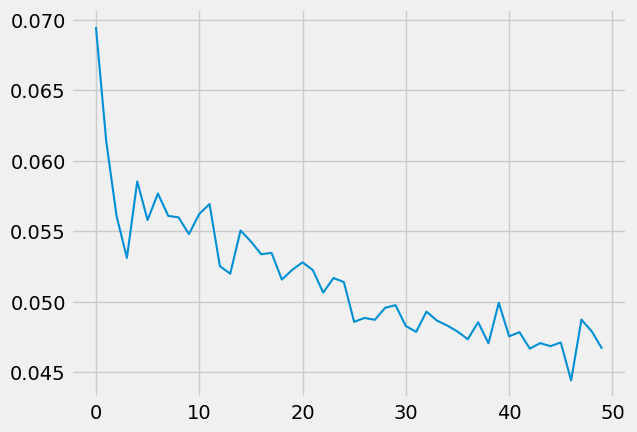

In [55]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [56]:
last_train_batch = scaled_train[-12:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

1/1 [==============================] - 0s 219ms/step


array([[0.58935934]], dtype=float32)

In [57]:
scaled_test[0]

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 29ms/step


In [58]:
test_predictions

[array([0.58935934], dtype=float32),
 array([0.4466425], dtype=float32),
 array([0.43312705], dtype=float32),
 array([0.3380521], dtype=float32),
 array([0.3426769], dtype=float32),
 array([0.34598896], dtype=float32),
 array([0.40481725], dtype=float32),
 array([0.46111995], dtype=float32),
 array([0.47475177], dtype=float32),
 array([0.46261027], dtype=float32),
 array([0.48757485], dtype=float32),
 array([0.47684628], dtype=float32),
 array([0.37396365], dtype=float32),
 array([0.32892537], dtype=float32),
 array([0.30748785], dtype=float32),
 array([0.28309], dtype=float32),
 array([0.27245557], dtype=float32),
 array([0.26609942], dtype=float32),
 array([0.26950175], dtype=float32),
 array([0.276378], dtype=float32),
 array([0.27937067], dtype=float32),
 array([0.27842304], dtype=float32),
 array([0.28132403], dtype=float32),
 array([0.2797074], dtype=float32),
 array([0.26718536], dtype=float32),
 array([0.26005474], dtype=float32),
 array([0.25560543], dtype=float32),
 array([0.

In [59]:
test.head()

y
year month day weekofmonth weekday hijri_month hijri_day           
2023 5     9   2           1       10          19          76067000
           10  2           2       10          20          34596000
           11  2           3       10          21          39549000
           12  2           4       10          22         178082000
           13  2           5       10          23         216496000

In [60]:
true_predictions = scaler.inverse_transform(test_predictions)

In [61]:
test.loc[:, 'Predictions'] = true_predictions
test.head()

C:\Users\khali\AppData\Local\Temp\ipykernel_6596\1567470468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predictions'] = true_predictions


y   
year month day weekofmonth weekday hijri_month hijri_day              
2023 5     9   2           1       10          19          76067000  \
           10  2           2       10          20          34596000   
           11  2           3       10          21          39549000   
           12  2           4       10          22         178082000   
           13  2           5       10          23         216496000   

                                                           Predictions  
year month day weekofmonth weekday hijri_month hijri_day                
2023 5     9   2           1       10          19         2.248451e+08  
           10  2           2       10          20         1.704992e+08  
           11  2           3       10          21         1.653526e+08  
           12  2           4       10          22         1.291485e+08  
           13  2           5       10          23         1.309097e+08

<Axes: xlabel='year,month,day,weekofmonth,weekday,hijri_month,hijri_day'>

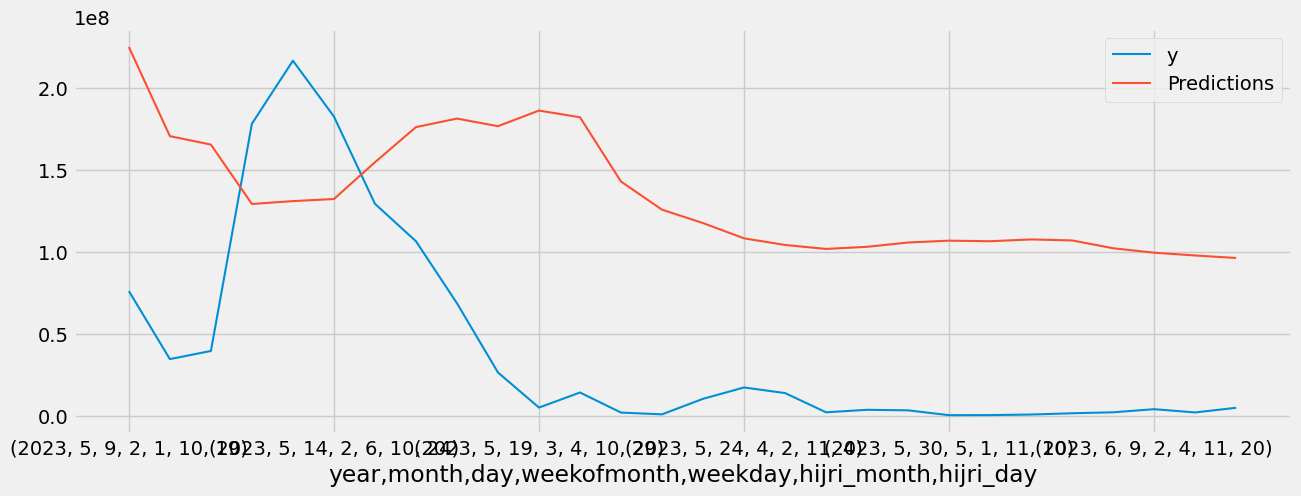

In [62]:
test.plot(figsize=(14,5))

In [63]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print("Root Mean Square Error (RMSE):", rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Square Error (RMSE): 111075576.53511323
Mean Value of Test Dataset: 40984500.0
